In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from numpy import log1p
from xgboost import XGBClassifier

In [3]:
data = pd.read_csv('train.csv')
data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [ ]:
data.drop(columns=['id'], inplace=True)


In [7]:
data.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [26]:
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

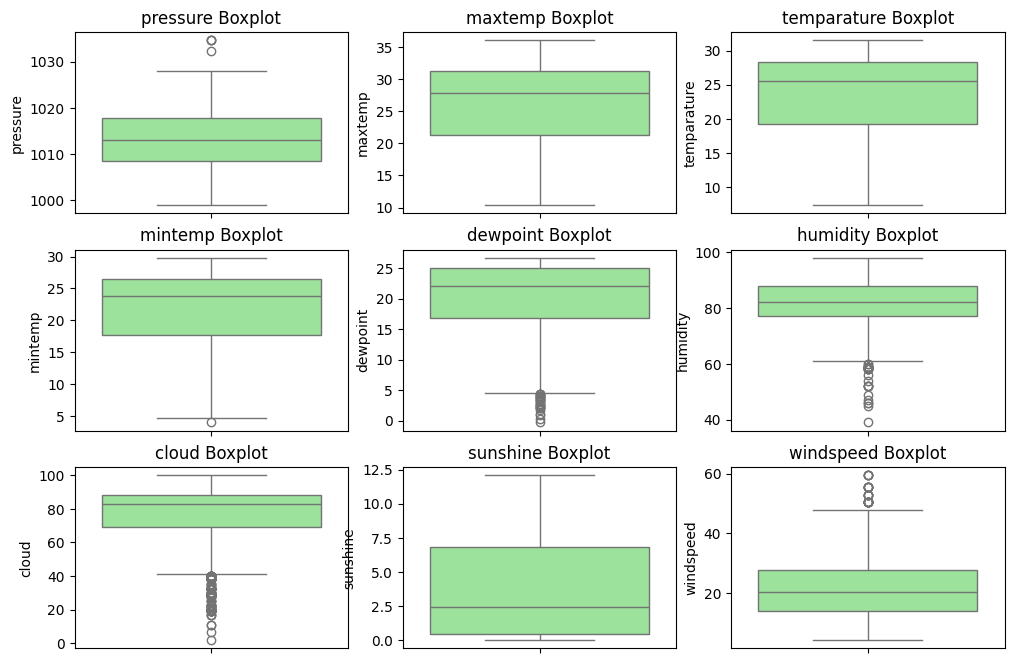

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    sns.boxplot(data=data, y=col, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'{col} Boxplot')

In [31]:
train=data.drop(target_variable,axis=1)
test=data[target_variable]
x_train,x_test,y_train,y_test=train_test_split(train,test,random_state=42,test_size=.2)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)

In [48]:
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (64, 64, 32)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=500), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", -grid.best_score_)

Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 32), 'learning_rate_init': 0.01}
Best score: -0.4516238589659678


In [32]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # no 'auto'
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter settings sampled
    scoring='roc_auc',         # Optimize for ROC AUC
    cv=5,                     # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

# Run hyperparameter search
random_search.fit(x_train, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate on test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(x_test)
y_proba = best_rf.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': np.int64(300), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': np.int64(5), 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       119
           1       0.86      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.77      0.79       438
weighted avg       0.84      0.85      0.84       438



In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],  # 'elasticnet' or 'none' if solver supports
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  # use saga for large/elasticnet
    'max_iter': [100, 200, 500]
}
logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # or 'roc_auc', 'f1' for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8721497761497762


In [36]:
test_data = pd.read_csv('test.csv')
test_final = test_data.drop(columns=['id'])

In [45]:
scale_test = scaler.transform(test_final)

In [46]:
y_pred = grid_search.predict(scale_test)
submission = pd.DataFrame({'id': test_data['id'], 'rainfall': y_pred})
submission.to_csv('submission.csv', index=False)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values